# Calculating neighborhood scores

In this notebook, I'll introduce two methods to calculate the neighborhood score of a given address. The first one takes user input, and returns a score based on the user's preferences. The second one builds up on the first one by using clustering to automate the process completely.

Please refer to [docs/score_calculation.pdf](../docs/score_calculation.pdf) for more details on score calculation.

### Method 1. Using given weights (Personal Interests Score)

Input:
- Facility count weights $w_i$ for each facility type (in our case $i \in \{1, \ldots, 8\}$)
- Commute-to-work score (optional, an ordinal value from 1 to 4)

Weight coefficients for four types of data we use for each address:
- $c_1$: facilty counts (per facility type)
- $c_2$: weighted average of ratings (per facility type)
- $c_3$: travel time to closest facility (per facility type)
- $c_4$: commute-to-work score (set to 0 if work address is not provided)

Consider min-max after log-scaling as the normalization, and let
- $f_i$ be the normalized facility counts
- $r_i$ be the normalized weighted average ratings
- $t_i$ be the normalized travel times to closest facilities
- $o$ be the normalized commute-to-work-score

Then the score is calculated using the following sum:
$$
s = c_1 \sum_i w_i f_i + c_2 \sum_i w_i r_i + c_3 \sum_i w_i (1 - t_i) + c_4 o
$$

*Remark: We require the input to satisfy $\sum_i w_i = 1$ and $\sum_k c_k = 1$ .*

### Method 2. Using clustering without any weight input* (Neighborhood Vibe Score)

Motivation:

- Automate the scoring process; use the dataset of addresses only
- Score a neighborhood based on its characteristics; level the playing field for rural/suburban

Calculation steps:

- Step 1: Using all available data, apply elbow rule on k-means clustering to determine the optimal $k$. Data used includes facility counts, weighted average ratings, travel times to closest facilities and population of the neighborhood.

- Step 2: Divide addresses into clusters using k-means with this $k$.

- Step 3: On each cluster, calculate weights as median / (1 + stdev) of facility counts per facility type (adjusted to have sum 1). This gives a cluster-specific weight set.

- Step 4: For each address, calculate a cluster-specific score using the weights determined in Step 3 and the previuos method.

*Remark: I chose to fix $c_i$ for every cluster for simplicity, but this could be changed to be cluster-specific too.*

---

- [Method 1](#method1)
    - [Three Score Examples](#method1_examples)
    - [Comparing three scores on addresses](#method1_all_scores)

- [Using Method 2](#method2)

---

In [1]:
import json
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
pd.set_option('display.max_columns', 50)

## Processing data from json files

In [2]:
def get_files(directory):
    return [
        os.path.join(directory, file) for file in os.listdir(directory) \
            if file.endswith('.json')
        ]

In [3]:
directory = "../data/google_data_isochrone_pop_cgpt" # Google data
files = get_files(directory)

In [4]:
def get_datasets(files):
    res = {}

    for file in files:
        data_name = file.split('/')[-1].split('.')[0]
        with open(file, 'r') as f:
            res[data_name] = json.load(f)
    
    return res

In [5]:
datasets = get_datasets(files)

for k in datasets.keys():
    print(k)

Ex3_1006_Lausanne_Av_d_Ouchy_58
Ex1_8004_Zurich_Werdgartengasse_4
Ex5_6319_Allenwinden_Winzruti_39
Ex2_3027_Bern_Colombstrasse_39
Ex4_8355_Aadorf_Bruggwiesenstrasse_5
Ex7_8003_Zurich_Birmensdorferstrasse_108
Ex6_8005_Zurich_Heinrichstrasse_200


----

<a id="method1"></a>
# Method 1: Using given weights

In [6]:
# Set facility types as a global variable
facility_types = [
    "bars",
    "restaurants",
    "kindergarten",
    "public_transportation",
    "gym_fitness",
    "grocery_stores_supermarkets",
    "gas_ev_charging",
    "schools"
]

In [7]:
# Helper function for time entries
def parse_time(time_str):
    """
    Parses a time string and returns the number of minutes.
    """
    if time_str == 'Travel time not available':
        return float('inf')  # If not available, treat as infinitely far
    parts = time_str.split()
    if len(parts) == 2:  # Format: "X mins"
        return int(parts[0])
    elif len(parts) == 4:  # Format: "X hours Y mins"
        return int(parts[0]) * 60 + int(parts[2])
    else:
        return float('inf')  # Unable to parse, treat as infinitely far

#### Process data from datasets to calculate weighted average rating and total rating count per facility

In [8]:
def extract_facility_data(json_data):
    facility_data = {
        "facility_counts": [],
        "min_travel_times": [],
        "weighted_avg_ratings": [],
        "total_ratings_counts": [],
        "total_population": json_data.get('population', {}).get('total_pop', None)
    }
    
    for ftype_group, group_data in json_data['facilities'].items():
        # Facility counts
        facility_data["facility_counts"].append(group_data['count'])
        
        # Minimum travel time
        try:
            min_travel_time = parse_time(group_data['closest']['travel_time'])
        except KeyError:
            min_travel_time = None
        facility_data["min_travel_times"].append(min_travel_time)
        
        # Weighted average rating
        total_weighted_rating = 0
        total_ratings_count = 0
        for facility in group_data['data']:
            if facility['rating'] != 'No rating available' and facility['num_ratings'] >= 3:
                rating = float(facility['rating'])
                ratings_count = int(facility['num_ratings'])
                total_weighted_rating += rating * ratings_count
                total_ratings_count += ratings_count
        
        if total_ratings_count > 0:
            weighted_avg_rating = total_weighted_rating / total_ratings_count
        else:
            weighted_avg_rating = None  # Handle case with no valid ratings

        facility_data["weighted_avg_ratings"].append(weighted_avg_rating)
        facility_data["total_ratings_counts"].append(total_ratings_count)

    return facility_data

#### Put facility counts, weighted rating averages and min travel times in a dataframe

In [9]:
def make_count_table(datasets):
    res = []

    for data_name, data in datasets.items():
        count_data = {gp: data['facilities'][gp]['count'] for gp in facility_types}
        weighted_avg_ratings = {f"{gp}_avg_rating": None for gp in facility_types}
        min_travel_times = {f"{gp}_min_travel_time": None for gp in facility_types}

        facility_data = extract_facility_data(data)

        for i, gp in enumerate(facility_types):
            weighted_avg_ratings[f"{gp}_avg_rating"] = facility_data["weighted_avg_ratings"][i]
            min_travel_times[f"{gp}_min_travel_time"] = facility_data["min_travel_times"][i]

        count_data.update(weighted_avg_ratings)
        count_data.update(min_travel_times)
        count_data['address'] = data['original_address']['address']
        count_data['total_population'] = facility_data['total_population']

        res.append(count_data)
    
    df = pd.DataFrame(res)

    cols = df.columns.tolist()
    cols.insert(0, cols.pop(cols.index('address')))
    df = df[cols]

    return df

In [10]:
facilities = make_count_table(datasets)
facilities

,address,bars,restaurants,kindergarten,public_transportation,gym_fitness,grocery_stores_supermarkets,gas_ev_charging,schools,bars_avg_rating,restaurants_avg_rating,kindergarten_avg_rating,public_transportation_avg_rating,gym_fitness_avg_rating,grocery_stores_supermarkets_avg_rating,gas_ev_charging_avg_rating,schools_avg_rating,bars_min_travel_time,restaurants_min_travel_time,kindergarten_min_travel_time,public_transportation_min_travel_time,gym_fitness_min_travel_time,grocery_stores_supermarkets_min_travel_time,gas_ev_charging_min_travel_time,schools_min_travel_time,total_population
0,"1006 Lausanne, Av. d'Ouchy 58",12,12,22,28,15,15,14,5,4.124159,4.316071,4.471975,4.475700,4.476869,4.438421,4.471581,4.041176,1.0,1,1,1,1,1,1,2.0,9994
1,"8004 Zürich, Werdgartengasse 4",4,9,6,34,14,14,4,6,4.095086,4.240169,4.354269,4.323185,4.135434,4.248971,4.262181,3.866667,5.0,5,3,3,3,2,3,2.0,20076
2,"6319 Allenwinden, Winzrüti 39",0,1,18,14,9,9,9,0,NaN,4.500000,4.667606,4.667606,4.667606,4.667606,4.667606,NaN,NaN,9,4,4,4,4,4,NaN,1026
3,"3027 Bern, Colombstrasse 39",4,20,20,22,14,18,12,3,3.913508,4.135556,4.107676,4.111797,4.133018,4.141313,4.115693,NaN,5.0,3,5,3,1,4,5,4.0,8419
4,"8355 Aadorf, Bruggwiesenstrasse 5",3,5,28,15,18,15,16,0,4.668421,4.481648,4.720053,4.720053,4.697163,4.522969,4.521607,NaN,5.0,3,4,4,4,4,4,NaN,2321
5,"8003 Zürich, Birmensdorferstrasse 108",2,4,8,37,13,12,5,4,4.400000,4.175047,4.101898,4.121689,3.972623,4.213057,4.023362,3.669231,7.0,8,3,3,3,1,3,3.0,26287
6,"8005 Zürich, Heinrichstrasse 200",13,15,16,37,16,21,12,4,4.266764,4.201067,4.117578,4.119822,4.127070,4.149937,4.118266,2.528421,1.0,1,4,3,3,1,1,3.0,16421


### Normalization and weighted sum

In [11]:
# Combined normalization function
def normalize(values):
    log_values = np.log1p(values)
    
    min_val = np.min(log_values)
    max_val = np.max(log_values)

    if min_val == max_val:
        return np.zeros_like(log_values)
    
    normalized_values = (log_values - min_val) / (max_val - min_val)
    
    # Replace any NaNs or infinities that may have slipped through with zeros
    normalized_values = np.nan_to_num(normalized_values, nan=0.0, posinf=0.0, neginf=0.0)
    
    return normalized_values

`work_travel_value` gives the value about traveling to work, an integer between 1 and 4.

In [12]:
def calculate_scores(df, facility_weights, weight_coeffs, work_travel_value=4):
    # Create a copy of the input dataframe to avoid modifying the original
    df_copy = df.copy()

    # Get weight coefficients from the dictionary
    weight_f = weight_coeffs['facility_counts']
    weight_r = weight_coeffs['average_ratings']
    weight_t = weight_coeffs['minimum_travel_times']
    weight_o = weight_coeffs.get('work_travel_value', 0)

    # Initialize score column in the copy
    df_copy['score'] = 0

    if weight_o == 0:
        for gp, weight in facility_weights.items():
            # Normalize the facility counts
            normalized_counts = normalize(df_copy[gp].values)

            # Normalize the weighted average ratings
            normalized_ratings = normalize(df_copy[f'{gp}_avg_rating'].fillna(0).values)

            # Normalize the minimum travel time
            normalized_travel_times = normalize(df_copy[f'{gp}_min_travel_time'].fillna(np.inf).replace(np.inf, 0).values)
            normalized_travel_times = 1 - normalized_travel_times

            # Calculate the weighted sum for each facility type
            df_copy['score'] += weight * (weight_f * normalized_counts + 
                                          weight_r * normalized_ratings + 
                                          weight_t * normalized_travel_times)
    else:
        # Normalize the ordinal value
        normalized_work_travel_value = (work_travel_value - 1) / 3

        for gp, weight in facility_weights.items():
            # Normalize the facility counts
            normalized_counts = normalize(df_copy[gp].values)

            # Normalize the weighted average ratings
            normalized_ratings = normalize(df_copy[f'{gp}_avg_rating'].fillna(0).values)

            # Normalize the minimum travel time
            normalized_travel_times = normalize(df_copy[f'{gp}_min_travel_time'].fillna(np.inf).replace(np.inf, 0).values)
            normalized_travel_times = 1 - normalized_travel_times

            # Calculate the weighted sum for each facility type
            df_copy['score'] += weight * (weight_f * normalized_counts + 
                                          weight_r * normalized_ratings + 
                                          weight_t * normalized_travel_times)

        # Incorporate the normalized ordinal value
        df_copy['score'] = (1 - weight_o) * df_copy['score'] + weight_o * normalized_work_travel_value

    # Scale the scores to a percentage
    df_copy['score'] *= 100
    df_copy['score'] = df_copy['score'].round().astype(int)

    return df_copy


### Plotting function

In [13]:
def plot_nhd_scores(df, facility_weights, weight_coeffs, priorities):
    df_scores = calculate_scores(df, facility_weights, weight_coeffs)
    score_sorted = df_scores.sort_values(by='score', ascending=False)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10),
                                   gridspec_kw={'width_ratios': [1, 3]})
    
    # Left subplot for priorities, weights, and weight coefficients
    ax1.axis('off')
    
    # Facility Priorities
    ax1.text(0.05, 0.83, "Facility priorities:", fontsize=14, fontweight='bold')
    ax1.text(0.05, 0.80, priorities, fontsize=14, va='top')
    
    # Facility Weights
    ax1.text(0.05, 0.65, "Weights of facility types:", fontsize=14, fontweight='bold')
    weight_text = "\n".join([f"{k}: {v:.2f}" for k, v in facility_weights.items()])
    ax1.text(0.05, 0.62, weight_text, fontsize=14, va='top')
    
    # Weight Coefficients
    ax1.text(0.05, 0.35, "Weight Coefficients:", fontsize=14, fontweight='bold')
    coeff_text = "\n".join([f"{k}: {v:.2f}" for k, v in weight_coeffs.items()])
    ax1.text(0.05, 0.32, coeff_text, fontsize=14, va='top')
    
    # Right subplot for the barplot
    sns.barplot(data=score_sorted, x='score', y='address', color='lightblue', ax=ax2)
    
    # Values on bars as labels
    ax2.bar_label(ax2.containers[0], fontsize=16, color='darkblue', weight='bold', label_type='edge')
    
    # Increase address text size
    ax2.tick_params(axis='y', labelsize=14)
    
    ax2.set_title('Neighborhood Scores: From 0 to 100', fontsize=16)
    ax2.set_xlabel('')
    ax2.set_ylabel('')
    ax2.set_xlim([0, 100])  # Set limit based on the score range
    
    plt.tight_layout()
    plt.show()

<a id="method1_examples"></a>
## Method 1 Examples

I'll apply the same set of weight coefficients to all examples for simplicity. In general, these could be custom fit to the neighborhood, for instance, after clustering.

Note that `'work_travel_value': 0` means that there is no input about commute to work in these examples.

In [14]:
weight_coeffs = {
    'facility_counts': 0.8,
    'average_ratings': 0.1,
    'minimum_travel_times': 0.1,
    'work_travel_value': 0
}

### Example 1

facility_priorities:
- schools
- grocery stores
- gas stations

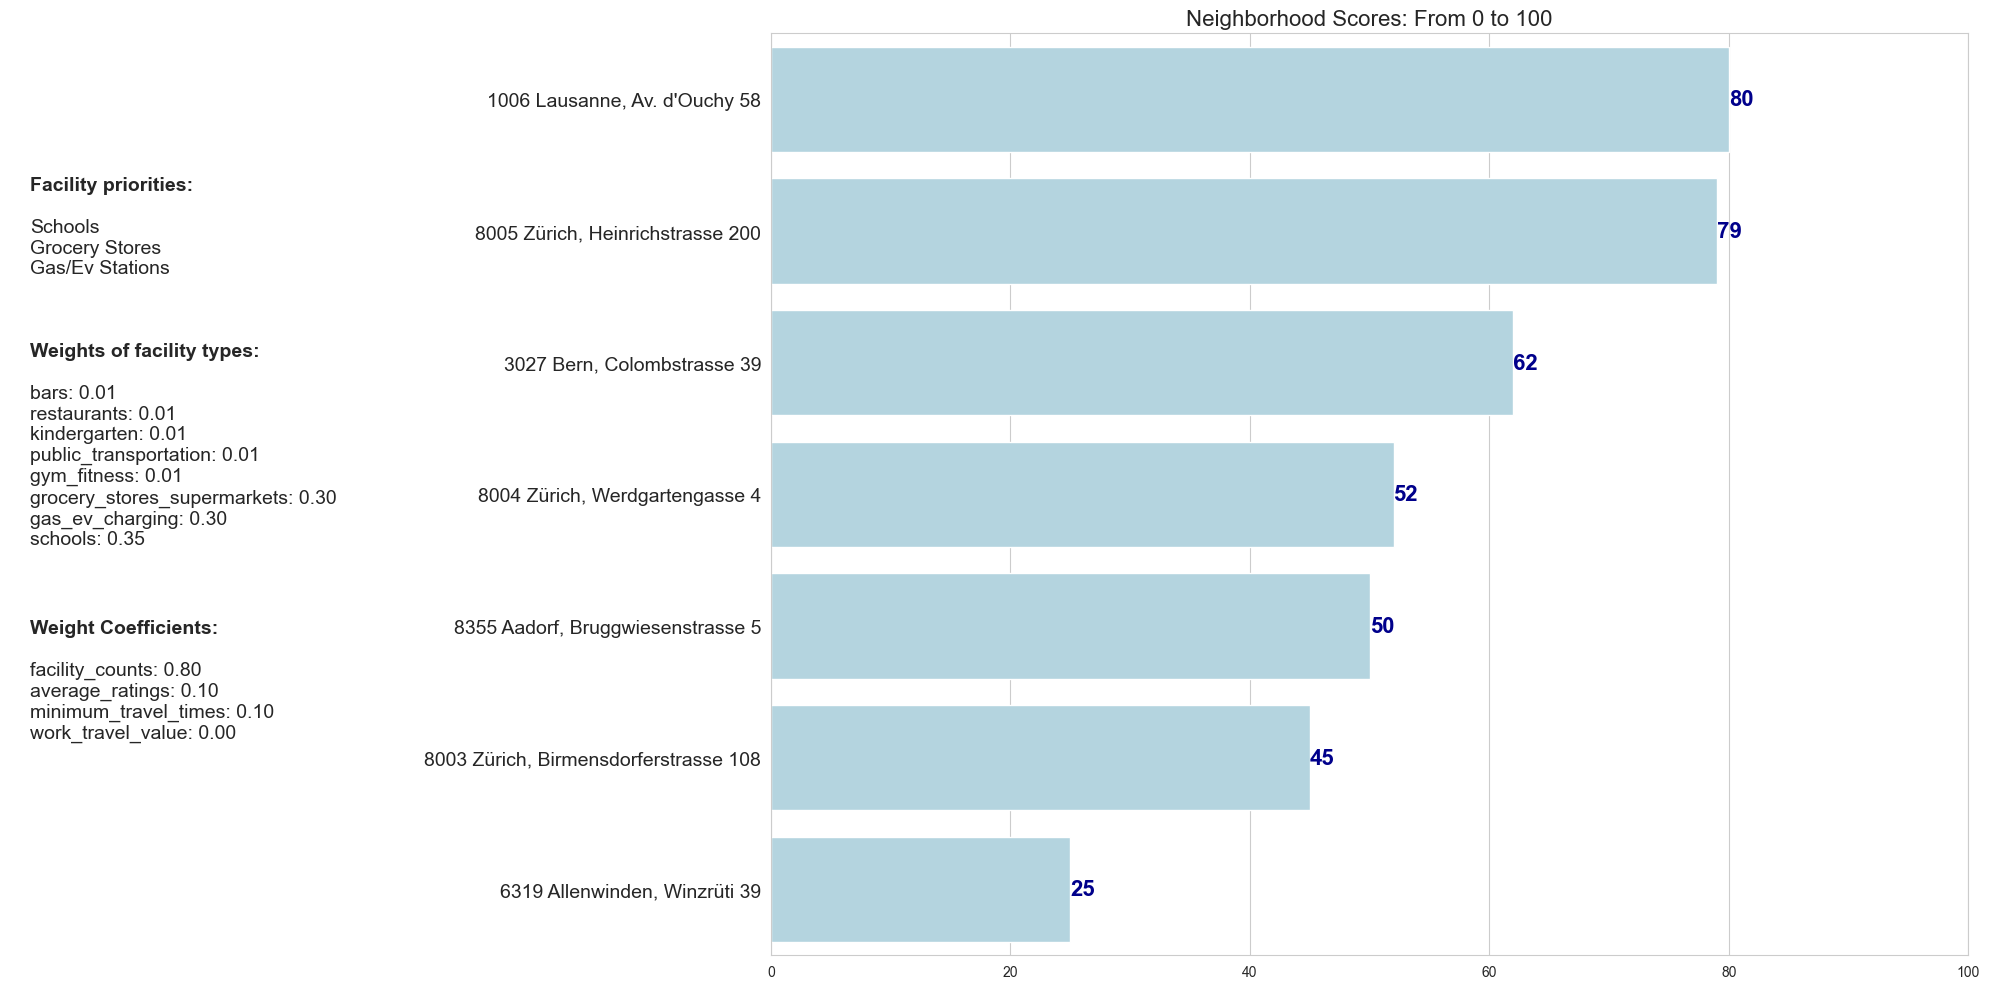

In [15]:
facility_priorities = "Schools\nGrocery Stores\nGas/Ev Stations"

# Score 1
facility_weights = {
    'bars': 0.01,
    'restaurants': 0.01,
    'kindergarten': 0.01,
    'public_transportation': 0.01,
    'gym_fitness': 0.01,
    'grocery_stores_supermarkets': 0.3,
    'gas_ev_charging': 0.3,
    'schools': 0.35
}

# sum(facility_weights.values())

plot_nhd_scores(facilities, facility_weights, weight_coeffs, facility_priorities)


In [16]:
ex1 = calculate_scores(facilities, facility_weights, weight_coeffs)[['address', 'score']]
ex1

,address,score
0,"1006 Lausanne, Av. d'Ouchy 58",80
1,"8004 Zürich, Werdgartengasse 4",52
2,"6319 Allenwinden, Winzrüti 39",25
3,"3027 Bern, Colombstrasse 39",62
4,"8355 Aadorf, Bruggwiesenstrasse 5",50
5,"8003 Zürich, Birmensdorferstrasse 108",45
6,"8005 Zürich, Heinrichstrasse 200",79


## Example 2

Priorities:
- bars
- restaurants
- public transportation

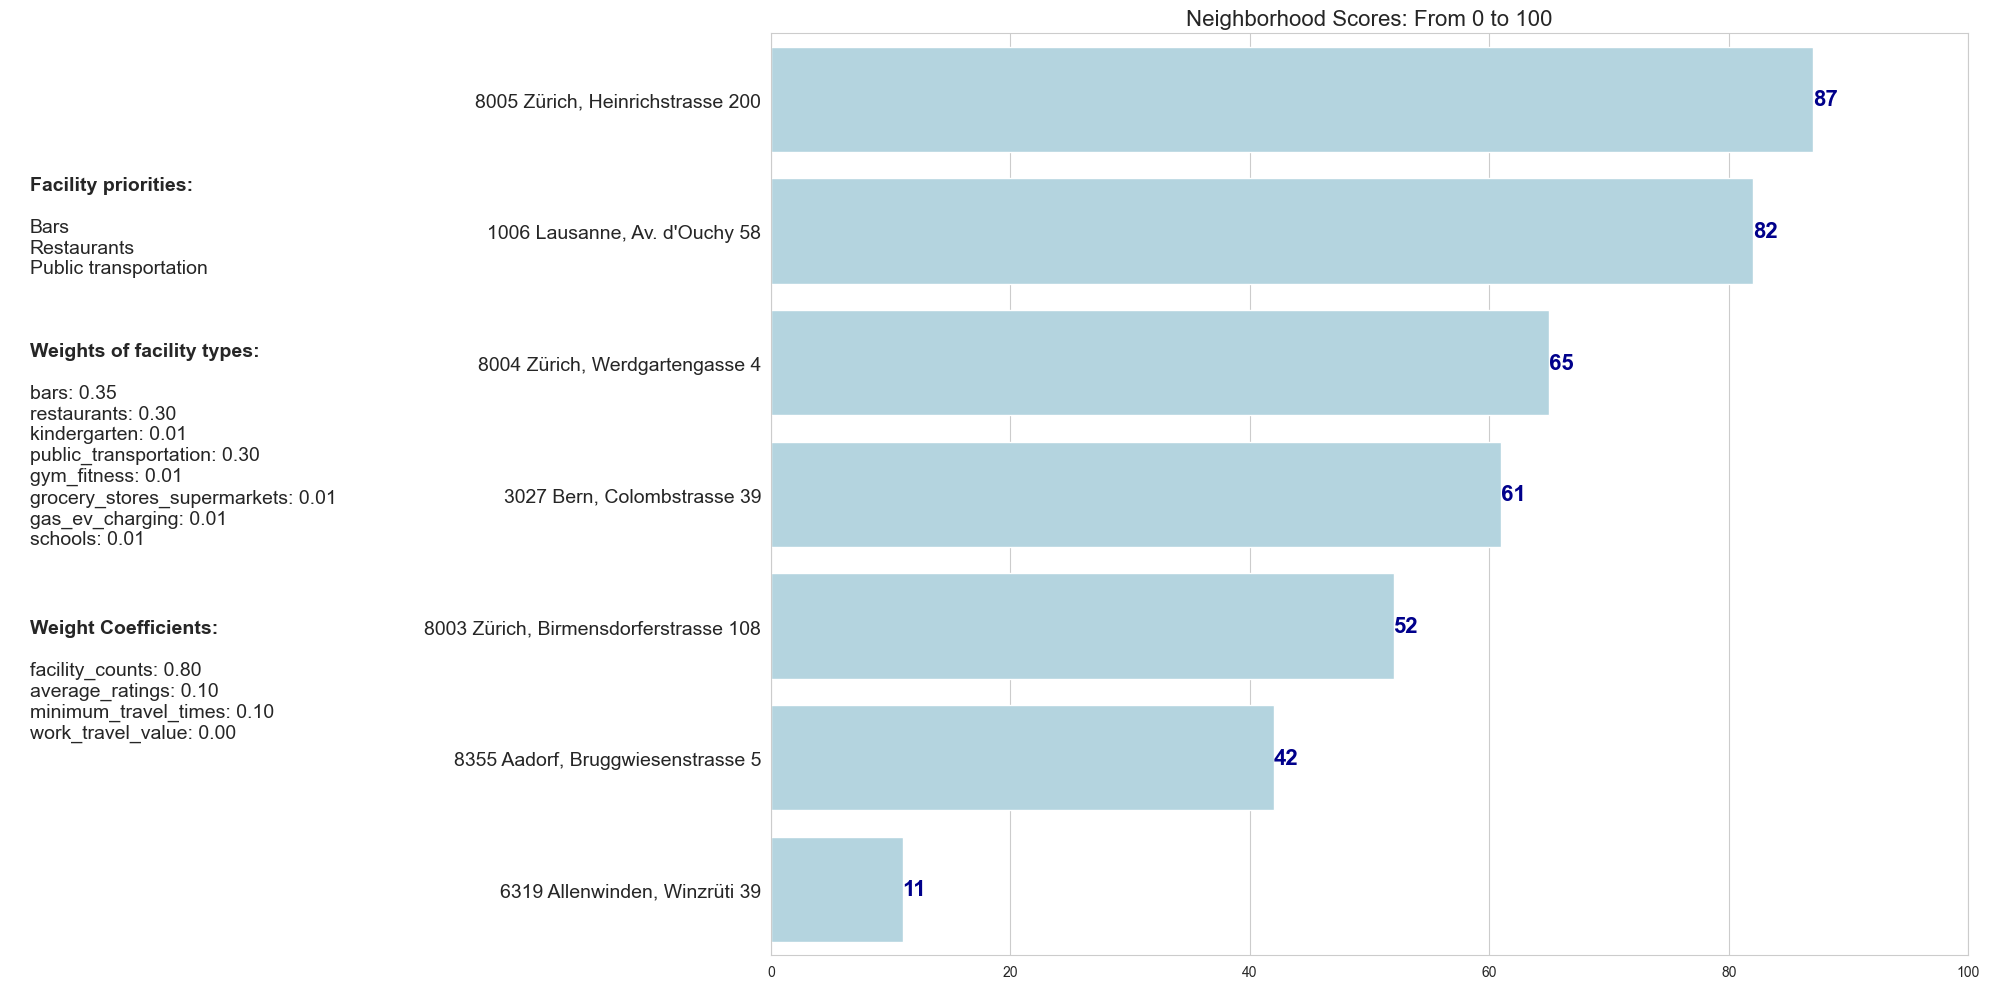

In [17]:
facility_priorities = "Bars\nRestaurants\nPublic transportation"

# Score 2
facility_weights = {
    'bars': 0.35,
    'restaurants': 0.3,
    'kindergarten': 0.01,
    'public_transportation': 0.3,
    'gym_fitness': 0.01,
    'grocery_stores_supermarkets': 0.01,
    'gas_ev_charging': 0.01,
    'schools': 0.01
}

# sum(facility_weights.values())

plot_nhd_scores(facilities, facility_weights, weight_coeffs, facility_priorities)

In [18]:
ex2 = calculate_scores(facilities, facility_weights, weight_coeffs)[['address', 'score']]
ex2

,address,score
0,"1006 Lausanne, Av. d'Ouchy 58",82
1,"8004 Zürich, Werdgartengasse 4",65
2,"6319 Allenwinden, Winzrüti 39",11
3,"3027 Bern, Colombstrasse 39",61
4,"8355 Aadorf, Bruggwiesenstrasse 5",42
5,"8003 Zürich, Birmensdorferstrasse 108",52
6,"8005 Zürich, Heinrichstrasse 200",87


## Example 3

Priorities:
- kindergarten
- fitness
- grocery stores

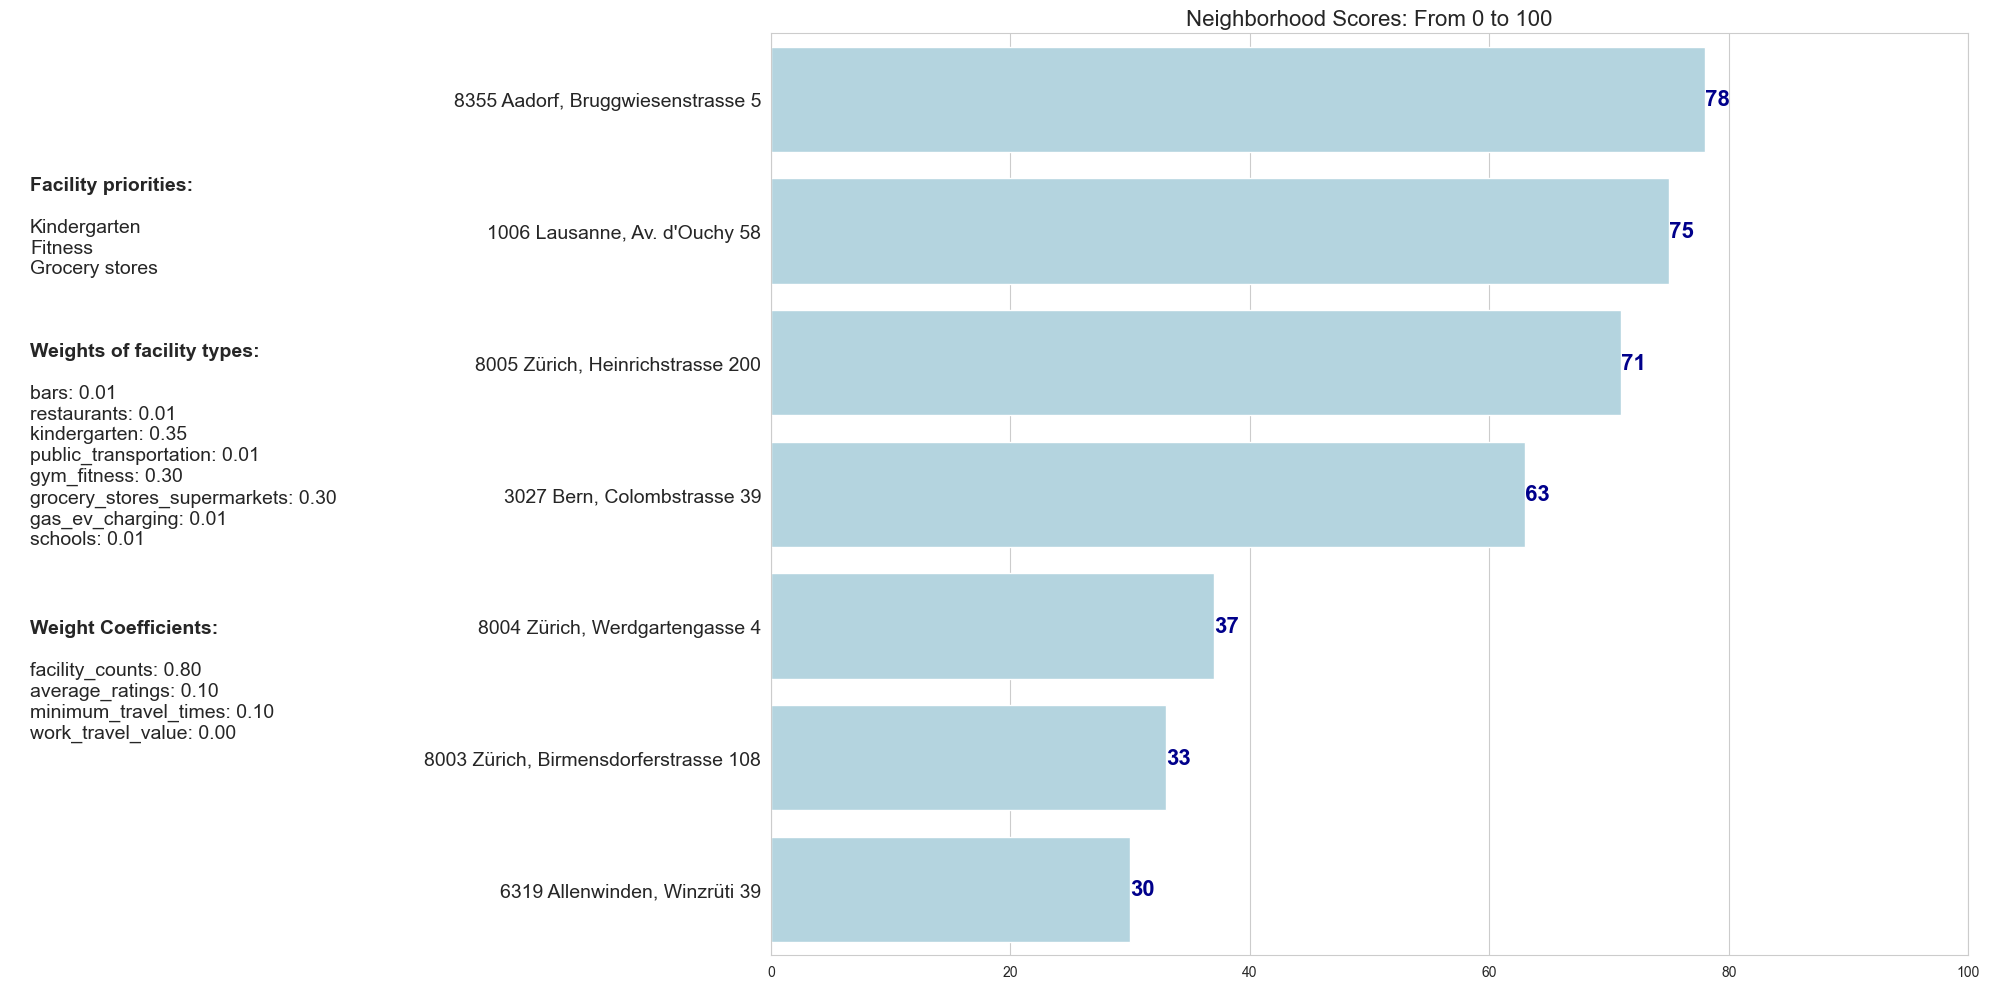

In [19]:
facility_priorities = "Kindergarten\nFitness\nGrocery stores"

# Score 3
facility_weights = {
    'bars': 0.01,
    'restaurants': 0.01,
    'kindergarten': 0.35,
    'public_transportation': 0.01,
    'gym_fitness': 0.3,
    'grocery_stores_supermarkets': 0.3,
    'gas_ev_charging': 0.01,
    'schools': 0.01
}

# sum(facility_weights.values())

plot_nhd_scores(facilities, facility_weights, weight_coeffs, facility_priorities)

In [20]:
ex3 = calculate_scores(facilities, facility_weights, weight_coeffs)[['address', 'score']]
ex3

,address,score
0,"1006 Lausanne, Av. d'Ouchy 58",75
1,"8004 Zürich, Werdgartengasse 4",37
2,"6319 Allenwinden, Winzrüti 39",30
3,"3027 Bern, Colombstrasse 39",63
4,"8355 Aadorf, Bruggwiesenstrasse 5",78
5,"8003 Zürich, Birmensdorferstrasse 108",33
6,"8005 Zürich, Heinrichstrasse 200",71


<a id="method1_all_scores"></a>
## All three scores for each address

In [21]:
df_merged_init = pd.merge(ex1, ex2, on='address', suffixes=['_1', '_2'])
scores = pd.merge(df_merged_init, ex3, on='address')
scores.rename(columns={'score':'score_3'}, inplace=True)

scores

,address,score_1,score_2,score_3
0,"1006 Lausanne, Av. d'Ouchy 58",80,82,75
1,"8004 Zürich, Werdgartengasse 4",52,65,37
2,"6319 Allenwinden, Winzrüti 39",25,11,30
3,"3027 Bern, Colombstrasse 39",62,61,63
4,"8355 Aadorf, Bruggwiesenstrasse 5",50,42,78
5,"8003 Zürich, Birmensdorferstrasse 108",45,52,33
6,"8005 Zürich, Heinrichstrasse 200",79,87,71


In [22]:
def plot_scores_for_address(scores, addresses, text):
    fig, axes = plt.subplots(1, len(addresses), figsize=(20, 6), sharey=True)
    
    # Loop through each address and plot the scores
    for i, address in enumerate(addresses):
        df_filtered = scores[scores['address'] == address]
        
        # Melt the dataframe
        df_melted = df_filtered.melt(id_vars=['address'], 
                                     value_vars=['score_1', 'score_2', 'score_3'],
                                     var_name='Score Type', 
                                     value_name='Score')
        
        barplot = sns.barplot(data=df_melted,
                              x='Score Type', y='Score',
                              hue='Score Type', palette='Dark2',
                              ax=axes[i])
        
        # Add title and labels
        axes[i].set_title(f'{address}', fontsize=12)
        axes[i].set_xlabel('', fontsize=12)
        if i == 0:
            axes[i].set_ylabel('Score: From 0 to 100', fontsize=12)
        else:
            axes[i].set_ylabel('')
        
        # Add bar labels
        for container in barplot.containers:
            barplot.bar_label(container, fontsize=14,
                              color='black', weight='bold')

        axes[i].set_xticks([0, 1, 2])
        axes[i].set_xticklabels(['Score 1', 'Score 2', 'Score 3'])
    
    # Add the text below all plots
    plt.figtext(0.37, -0.2, text, ha='left', fontsize=16)
    
    plt.tight_layout()
    plt.show()

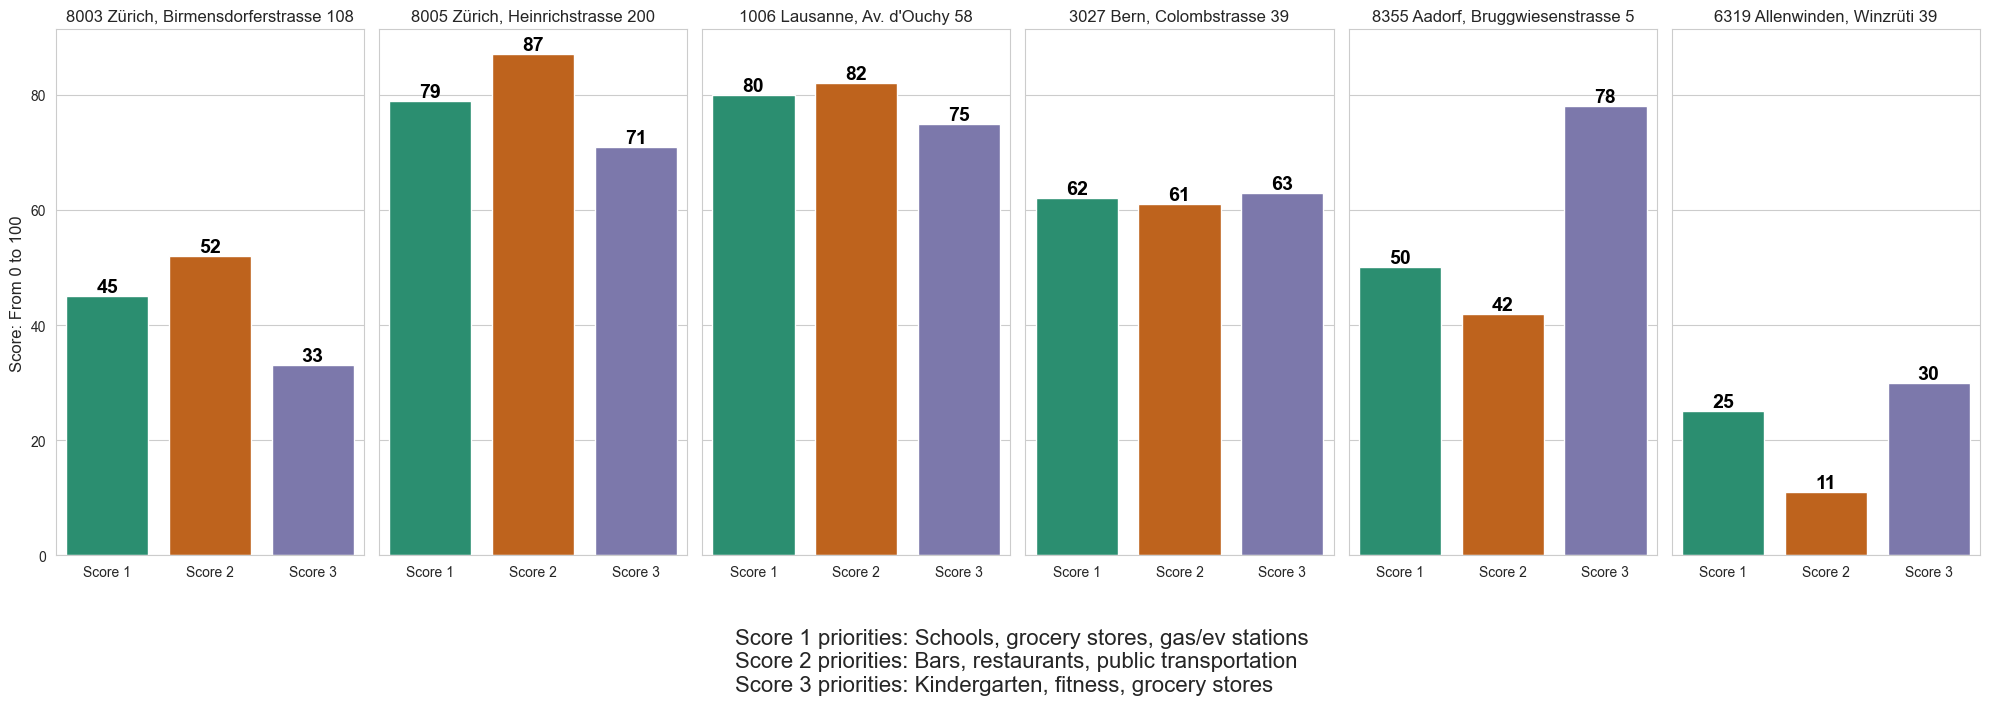

In [23]:
addresses = [
    ex1.loc[5]['address'],
    ex1.loc[6]['address'],
    ex1.loc[0]['address'],
    ex1.loc[3]['address'],
    ex1.loc[4]['address'],
    ex1.loc[2]['address']
]

text = """
Score 1 priorities: Schools, grocery stores, gas/ev stations
Score 2 priorities: Bars, restaurants, public transportation
Score 3 priorities: Kindergarten, fitness, grocery stores
"""

plot_scores_for_address(scores, addresses, text)

#### Taking the mean of the previous three scores

In [24]:
scores['avg_of_3_scores'] = scores[['score_1', 'score_2', 'score_3']].mean(axis=1).round().astype(int)
scores

,address,score_1,score_2,score_3,avg_of_3_scores
0,"1006 Lausanne, Av. d'Ouchy 58",80,82,75,79
1,"8004 Zürich, Werdgartengasse 4",52,65,37,51
2,"6319 Allenwinden, Winzrüti 39",25,11,30,22
3,"3027 Bern, Colombstrasse 39",62,61,63,62
4,"8355 Aadorf, Bruggwiesenstrasse 5",50,42,78,57
5,"8003 Zürich, Birmensdorferstrasse 108",45,52,33,43
6,"8005 Zürich, Heinrichstrasse 200",79,87,71,79


---

<a id="method2"></a>
# Method 2: Using clusters to automate scoring

In [25]:
from sklearn.cluster import KMeans

I'll use the same set of weight coefficients throughout for simplicity. In general, these weights can be determined using the clustering below as well.

In [26]:
weight_coeffs = {
    'facility_counts': 0.8,
    'average_ratings': 0.1,
    'minimum_travel_times': 0.1
}

The elbow method allows us to decide on an optimal number of clusteres, $k$.

In [27]:
def plot_elbow_method(features):
    inertia = []
    k_values = range(1, 7)
    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=1)
        kmeans.fit(features)
        inertia.append(kmeans.inertia_)
    
    plt.figure(figsize=(10, 6))
    plt.plot(k_values, inertia, 'm.-')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.title('Elbow Method (features used: counts, average ratings, min travel times and population)')
    plt.show()

I'll use the same normalization before kmeans; namely log + min-max.

In [28]:
df = facilities.copy()

for col in df.columns[1:]:
    df[col] = normalize(df[col].values)

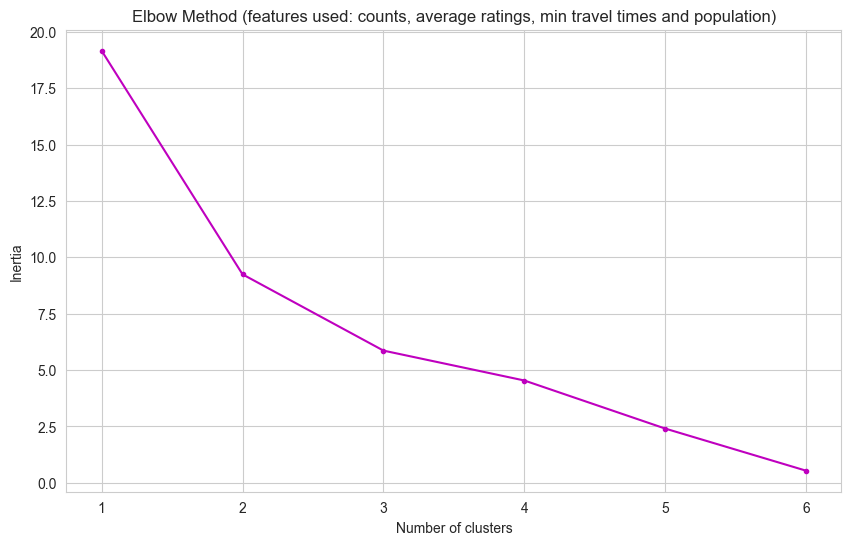

In [29]:
features = df.drop(columns=['address'])
plot_elbow_method(features)

#### Using k=2

In [30]:
kmeans = KMeans(n_clusters=2, random_state=1)
df['cluster'] = kmeans.fit_predict(features)

In [31]:
df

,address,bars,restaurants,kindergarten,public_transportation,gym_fitness,grocery_stores_supermarkets,gas_ev_charging,schools,bars_avg_rating,restaurants_avg_rating,kindergarten_avg_rating,public_transportation_avg_rating,gym_fitness_avg_rating,grocery_stores_supermarkets_avg_rating,gas_ev_charging_avg_rating,schools_avg_rating,bars_min_travel_time,restaurants_min_travel_time,kindergarten_min_travel_time,public_transportation_min_travel_time,gym_fitness_min_travel_time,grocery_stores_supermarkets_min_travel_time,gas_ev_charging_min_travel_time,schools_min_travel_time,total_population,cluster
0,"1006 Lausanne, Av. d'Ouchy 58",0.971919,0.796046,0.836919,0.709220,0.732260,0.596105,0.897724,0.920782,0.0,0.503886,0.612309,0.611677,0.710083,0.576454,0.708296,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.701762,1
1,"8004 Zürich, Werdgartengasse 4",0.609853,0.684467,0.000000,0.911528,0.631709,0.514251,0.000000,1.000000,0.0,0.294132,0.422169,0.360419,0.236852,0.212640,0.384910,0.0,0.0,0.682606,0.630930,0.756471,0.756471,0.442507,0.630930,0.0,0.916873,1
2,"6319 Allenwinden, Winzrüti 39",0.000000,0.000000,0.702504,0.000000,0.000000,0.000000,0.566401,0.000000,0.0,1.000000,0.919457,0.918069,0.961759,1.000000,1.000000,0.0,0.0,1.000000,0.834044,1.000000,1.000000,1.000000,0.834044,0.0,0.000000,0
3,"3027 Bern, Colombstrasse 39",0.609853,1.000000,0.772916,0.459847,0.631709,0.814063,0.780790,0.712414,0.0,0.000000,0.009896,0.000000,0.233393,0.000000,0.150939,0.0,0.0,0.430677,1.000000,0.756471,0.000000,1.000000,1.000000,0.0,0.648878,1
4,"8355 Aadorf, Bruggwiesenstrasse 5",0.525299,0.467221,1.000000,0.069431,1.000000,0.596105,1.000000,0.000000,0.0,0.951250,1.000000,1.000000,1.000000,0.734746,0.783721,0.0,0.0,0.430677,0.834044,1.000000,1.000000,1.000000,0.834044,0.0,0.251594,0
5,"8003 Zürich, Birmensdorferstrasse 108",0.416290,0.389683,0.176809,1.000000,0.524219,0.332756,0.148983,0.827087,0.0,0.111731,0.000000,0.017195,0.000000,0.142194,0.000000,0.0,0.0,0.934536,0.630930,0.756471,0.756471,0.000000,0.630930,0.0,1.000000,1
6,"8005 Zürich, Heinrichstrasse 200",1.000000,0.884351,0.624252,1.000000,0.826712,1.000000,0.780790,0.827087,0.0,0.184884,0.026831,0.013953,0.224869,0.017197,0.155106,0.0,0.0,0.000000,0.834044,0.756471,0.756471,0.000000,0.000000,0.0,0.854897,1


In [32]:
cluster_means = df[df.columns[1:]].groupby('cluster')[facility_types].median()
cluster_means.T

cluster,0,1
bars,0.262650,0.609853
restaurants,0.233611,0.796046
kindergarten,0.851252,0.624252
public_transportation,0.034715,0.911528
gym_fitness,0.500000,0.631709
grocery_stores_supermarkets,0.298053,0.596105
gas_ev_charging,0.783200,0.780790
schools,0.000000,0.827087


In [33]:
def simplex_projection(values):
    sum_values = np.sum(values)
    if sum_values == 0:
        return values
    return values / sum_values

Whichever facility is more frequent, gets larger weights. I'm playing to the strengths of the neighborhood.

In [34]:
cluster_weights = {}
for c in range(2):
    normalized_weights = simplex_projection(cluster_means.loc[c].values)
    cluster_weights[c] = {facility_types[i]: normalized_weights[i] for i in range(len(facility_types))}

In [35]:
cluster_weights

{0: {'bars': np.float64(0.08862873908812079),
  'restaurants': np.float64(0.0788298041077618),
  'kindergarten': np.float64(0.2872473471475692),
  'public_transportation': np.float64(0.011714418989851488),
  'gym_fitness': np.float64(0.1687205330014579),
  'grocery_stores_supermarkets': np.float64(0.10057520777321872),
  'gas_ev_charging': np.float64(0.26428394989202),
  'schools': np.float64(0.0)},
 1: {'bars': np.float64(0.10555896879077147),
  'restaurants': np.float64(0.13778684003390576),
  'kindergarten': np.float64(0.10805126244952763),
  'public_transportation': np.float64(0.15777553118468746),
  'gym_fitness': np.float64(0.10934200883923305),
  'grocery_stores_supermarkets': np.float64(0.1031793377118727),
  'gas_ev_charging': np.float64(0.13514621885224623),
  'schools': np.float64(0.14315983213775568)}}

I'll calculate the score for each address using the weights from the cluster it belongs to.

In [36]:
def calculate_cluster_score(df, cluster_weights, weight_coeffs):
    # Create a copy of the input dataframe to avoid modifying the original
    df_copy = df.copy()

    # Get weight coefficients from the dictionary
    weight_f = weight_coeffs['facility_counts']
    weight_r = weight_coeffs['average_ratings']
    weight_t = weight_coeffs['minimum_travel_times']

    # Initialize the score column
    df_copy['cluster_score'] = 0

    # Create a list to store scores
    scores = []

    for index, row in df_copy.iterrows():
        cluster = row['cluster']
        facility_weights = cluster_weights[cluster]

        score = 0
        for gp, weight in facility_weights.items():
            normalized_counts = row[gp]
            normalized_ratings = row[f'{gp}_avg_rating']
            normalized_travel_times = 1 - row[f'{gp}_min_travel_time']

            # Calculate the weighted sum for each facility type
            score += weight * (weight_f * normalized_counts + 
                               weight_r * normalized_ratings + 
                               weight_t * normalized_travel_times)

        scores.append(score)

    # Assign all scores at once
    df_copy['cluster_score'] = scores

    # Scale the scores to a percentage
    df_copy['cluster_score'] *= 100
    df_copy['cluster_score'] = df_copy['cluster_score'].round().astype(int)

    return df_copy

In [37]:
df_with_scores = calculate_cluster_score(df, cluster_weights, weight_coeffs)
df_with_scores[['address', 'cluster', 'cluster_score']]

,address,cluster,cluster_score
0,"1006 Lausanne, Av. d'Ouchy 58",1,79
1,"8004 Zürich, Werdgartengasse 4",1,53
2,"6319 Allenwinden, Winzrüti 39",0,39
3,"3027 Bern, Colombstrasse 39",1,63
4,"8355 Aadorf, Bruggwiesenstrasse 5",0,80
5,"8003 Zürich, Birmensdorferstrasse 108",1,46
6,"8005 Zürich, Heinrichstrasse 200",1,77


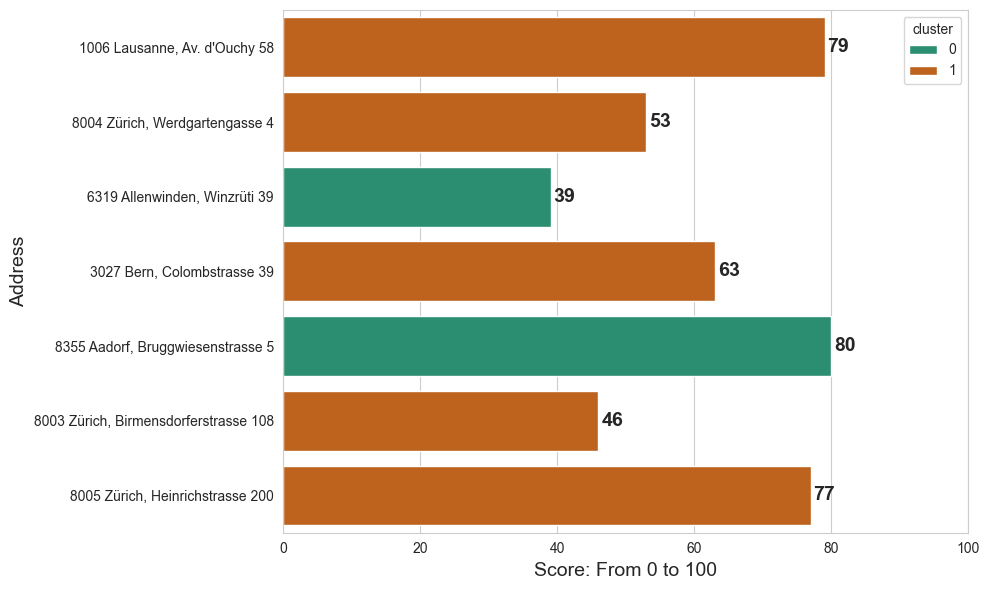

In [38]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.barplot(data=df_with_scores, y='address', x='cluster_score', hue='cluster', palette='Dark2')

for container in ax.containers:
    ax.bar_label(container, fontsize=14, weight='bold', label_type='edge', padding=2)

plt.xlim([0, 100])
plt.xlabel('Score: From 0 to 100', fontsize=14)
plt.ylabel('Address', fontsize=14)

plt.tight_layout()
plt.show()

It seems this method put rural areas in one cluster, and urban areas in the other. Ecah cluster's characteristics (facility medians) are used in the scoring, which allows each address to be evaluated according to its strong points.

In [39]:
def analyze_cluster_medians(df, facility_types):
    medians = df.groupby('cluster')[facility_types].median()
    
    # Calculate the range (max - min) for each feature across clusters
    feature_ranges = medians.max() - medians.min()
    
    # Sort features by their range in descending order
    return feature_ranges.sort_values(ascending=False).reset_index().rename(columns={'index':'facility_type', 0:'median_difference'})

def print_cluster_profiles_median(df, facility_types):
    medians = df.groupby('cluster')[facility_types].median().reset_index()
    # print("Cluster Profiles (Median):")
    # print(medians)
    print("\nFeature Importance based on Median Differences:")
    return analyze_cluster_medians(df, facility_types)

print_cluster_profiles_median(df_with_scores, facility_types)


Feature Importance based on Median Differences:


,facility_type,median_difference
0,public_transportation,0.876812
1,schools,0.827087
2,restaurants,0.562435
3,bars,0.347204
4,grocery_stores_supermarkets,0.298053
5,kindergarten,0.227000
6,gym_fitness,0.131709
7,gas_ev_charging,0.002410


Comparing median differences of facility counts per type between clusters gives a simple way to evaluate feature importance. It seems public transportation and schools were the most important factors in the clustering above.

### Comparing with the mean of the three example scores above

In [40]:
df_merged = pd.merge(df_with_scores, scores, on='address')
df2 = df_merged[['address', 'cluster_score', 'avg_of_3_scores']]

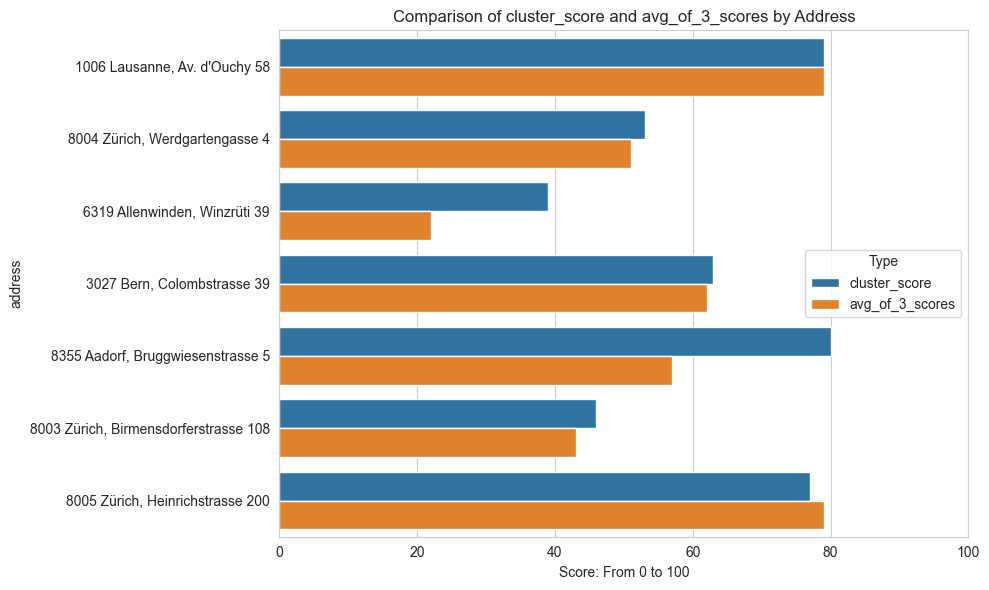

In [41]:
df_melted = df2.melt(id_vars='address', value_vars=['cluster_score', 'avg_of_3_scores'], var_name='Type', value_name='Score')

plt.figure(figsize=(10, 6))
sns.barplot(data=df_melted, y='address', x='Score', hue='Type')
plt.title('Comparison of cluster_score and avg_of_3_scores by Address')
plt.xlim([0, 100])
plt.xlabel('Score: From 0 to 100')
plt.tight_layout()
plt.show()

The mean of the three example scores above is somewhat arbitrary, they were just three scenarios that are quite different from each other. And this was seen in the variance of the scores for different addresses.

The clustering method provides an improvement in the sense that rural/suburban areas do not get dominated by urban areas, the automated clustering score gives a more balanced scoring methoid; this can be seen in the plot above.